In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import zipfile

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import keras

In [3]:
# import numpy as np
# import matplotlib.pyplot as plt

# def generate_gbm(start_price, mu, sigma, n_steps, dt):
#     prices = [start_price]
#     for _ in range(n_steps):
#         prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal()))
#     return np.array(prices)

# # Parameters
# start_price = 100
# mu = 0.0002  # Drift coefficient
# sigma = 0.01  # Volatility coefficient
# n_steps = 1000
# dt = 1  # Time step

# # Generate GBM prices
# gbm_prices = generate_gbm(start_price, mu, sigma, n_steps, dt)

# # Plot the generated prices
# plt.figure(figsize=(14, 7))
# plt.plot(gbm_prices)
# plt.title('Geometric Brownian Motion - Simulated Stock Prices')
# plt.xlabel('Time Steps')
# plt.ylabel('Price')
# plt.show()


In [4]:
# def generate_random_walk(start_price, n_steps):
#     returns = np.random.normal(0, 1, n_steps)
#     prices = start_price + np.cumsum(returns)
#     return prices

# # Parameters
# start_price = 100
# n_steps = 1_000_000

# # Generate random walk
# random_walk_prices = generate_random_walk(start_price, n_steps)

# # Plot the generated prices
# plt.figure(figsize=(14, 7))
# plt.plot(random_walk_prices)
# plt.title('Random Walk - Simulated Stock Prices')
# plt.xlabel('Time Steps')
# plt.ylabel('Price')
# plt.show()

# Data

In [5]:
df = pd.read_hdf('data/data.h5', 'SPY')
df.index = pd.to_datetime(df.index, unit='s')
df = np.rint(df * 100).astype(np.int32)
df

,Open,High,Low,Close,Volume
Date,,,,,
1998-07-01 09:32:00,738100,738100,737700,737700,25760000
1998-07-01 09:33:00,738400,738600,738100,738100,2440000
1998-07-01 09:34:00,738100,738600,738100,738600,250000
1998-07-01 09:35:00,738300,738300,737900,737900,90000
1998-07-01 09:36:00,738300,738300,738100,738100,300000
...,...,...,...,...,...
2023-03-31 15:55:00,4087600,4093400,4087400,4091800,156284100
2023-03-31 15:56:00,4091900,4093400,4090500,4093200,70754400
2023-03-31 15:57:00,4093300,4094100,4092400,4094000,80362600


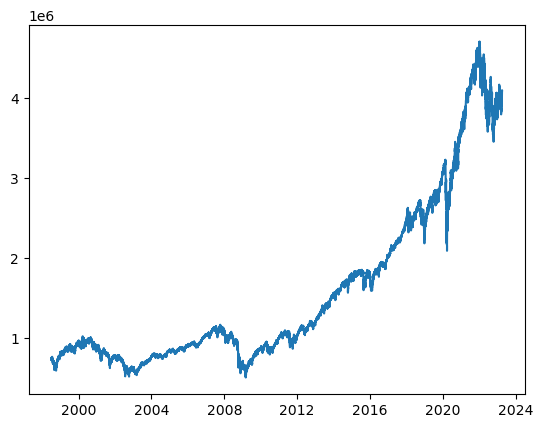

In [6]:
plt.plot(df['Close'])

# Pre-processing

(2399384, 1)


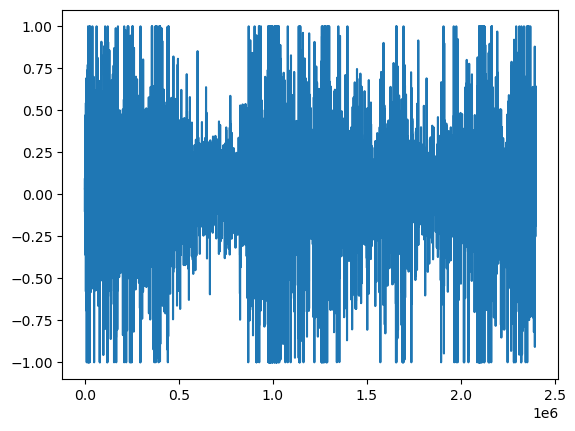

In [7]:
# select features
X = df[['Close']].values 
X = X.astype(np.float32)

# make data stationary using log returns
X = np.log(X)
X = np.diff(X, axis=0)

# remove 0.01% outliers
outliers = np.quantile(np.abs(X), 0.9999)
X = np.clip(X, -outliers, outliers)

# scale
X = X / np.max(np.abs(X))

assert(np.isnan(X).any() == False)

plt.plot(X[:, 0])
print(X.shape)

In [8]:
timesteps = 128
features = 1
batch_size = 16
steps = 1
length = len(X) - timesteps - steps
train_index = int(0.8 * length)

x_train = X[:train_index]
x_test = X[train_index:]

y_train = x_train[timesteps::timesteps]
y_test = x_test[timesteps::timesteps]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1919404, 1) (479980, 1)
(14995, 1) (3749, 1)


In [9]:
# window data
def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

x_train = window(x_train, timesteps, timesteps)
x_test = window(x_test, timesteps, timesteps)

print(x_train.shape, x_test.shape)

assert(x_train.shape[0] == y_train.shape[0])

(14995, 128, 1) (3749, 128, 1)


# Data Generation

In [10]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.data[idx]
            y_positive = self.data[idx+1]
            
            # base case
            # y_negative = np.zeros_like(y_positive)
            
            # flipping but not well (only do if non stationary data)
            # y_negative = np.max(y_positive) + np.min(y_positive) - y_positive
            
            # make y_negative normal distribution from same range as y_positive
            y_negative = np.random.normal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0])
            y_negative = np.clip(y_negative, -1.0, 1.0)
            y_negative = np.expand_dims(y_negative, -1)
            
            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [11]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

937
x shape: (16, 128, 1), y shape: (16, 128, 1), labels shape: (16, 1)


# Inspecting Windows

In [12]:
def window_plot(a, x, y, labels):
    plt.figure(figsize=(20, 4))
    
    # Plot the first window x[a]
    plt.subplot(1, 3, 1)
    plt.plot(x[a, :, 0], label='x[{}]'.format(a))
    plt.legend()
    plt.title(f'First Window x[{a}]')
    
    # Plot the corresponding y[a] with label
    plt.subplot(1, 3, 2)
    plt.plot(y[a, :, 0], label=f'y[{a}]: {bool(labels[a])}')
    plt.legend()
    plt.title(f'Corresponding y[{a}] with label {bool(labels[a])}')
    
    # Plot another window x[a+2] and corresponding y[a+2]
    plt.subplot(1, 3, 3)
    plt.plot(x[a+2, :, 0], label='x[{}]'.format(a+2))
    plt.plot(y[a, :, 0], label=f'y[{a}]: {bool(labels[a])}')
    plt.legend()
    plt.title(f'Window x[{a+2}] and Corresponding y[{a}]')

    plt.show()

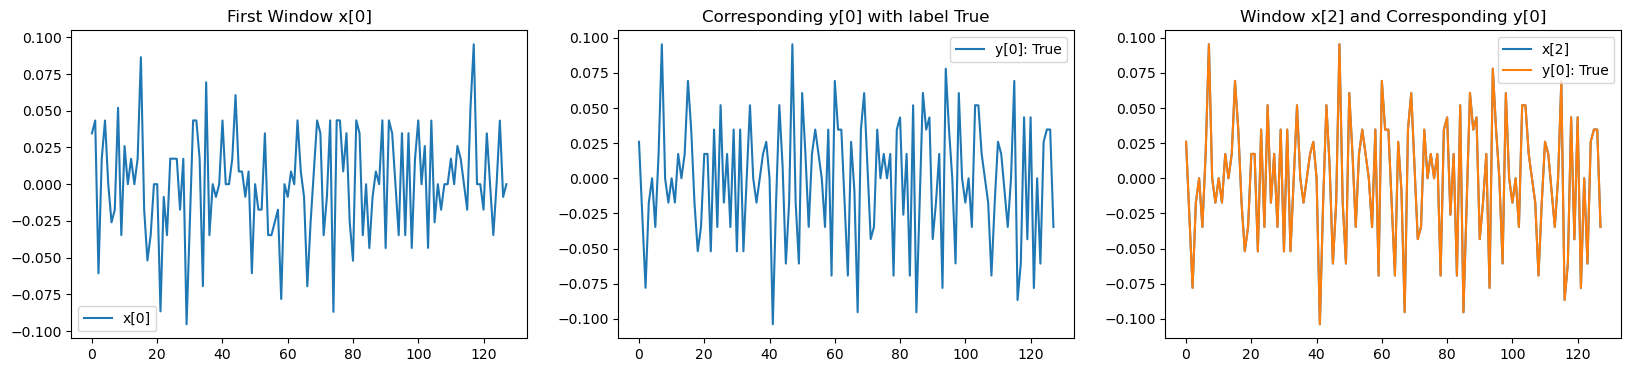

In [13]:
window_plot(0, x, y, labels)

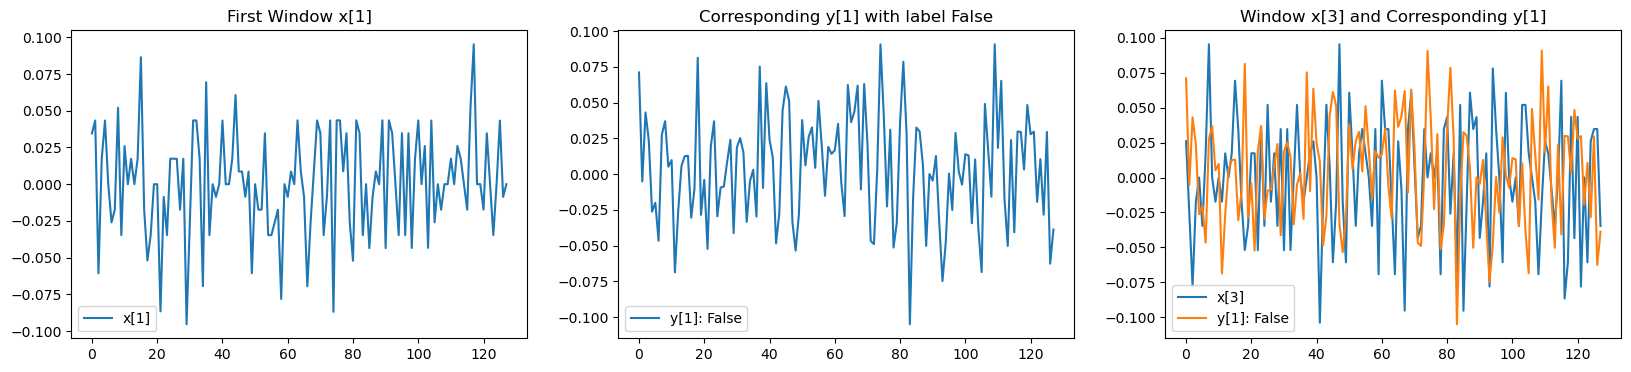

In [14]:
window_plot(1, x, y, labels)

# Model Architecture

In [29]:
# def network_encoder(x, code_size):
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(64, 3, activation='linear', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dense(units=256, activation='linear')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Flatten()(x)
#     x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
#     return x

def network_encoder(x, code_size):
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Dense(256, activation='linear')(x)
    x = Dense(128, activation='linear')(x)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    # x = Reshape((-1,1))(x)
    return x

In [30]:
code_size = 32
input_shape = (timesteps, features)

encoder_input = Input(input_shape)
encoder_output = network_encoder(encoder_input, code_size)
encoder_model = Model(encoder_input, encoder_output, name='encoder')
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 64)           256       
                                                                 
 dense_4 (Dense)             (None, 128, 128)          8320      
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                524320    
                                                                 
Total params: 532,896
Trainable params: 532,896
Non-trainable params: 0
_________________________________________________________________


In [31]:
x_input = Input(input_shape)
x_encoded = encoder_model(x_input)

# integrates information along the sequence
x_encoded = (Reshape((-1,1))(x_encoded))
context = GRU(256, return_sequences=False, name="context")(x_encoded)
# context = LSTM(256, return_sequences=False, name="context")(x_encoded)

# predict z-latent from context
preds = Dense(code_size, activation="linear", name="preds")(context)

y_input = Input(input_shape)
y_encoded = encoder_model(y_input)

dot_product = K.sum(y_encoded * preds, axis=-1)
# dot_product = K.batch_dot(y_encoded, preds, axes=1)
dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='contrastive')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "contrastive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 32)           532896      ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 reshape_3 (Reshape)            (None, 32, 1)        0           ['encoder[0][0]']      

2024-07-28 18:04:02.309535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 18:04:02.309989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 18:04:02.310501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 64
epochs = 10

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen, callbacks=checkpoint_callback)

Epoch 1/10


2024-07-28 18:04:09.842325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-07-28 18:04:09.991976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 18:04:09.992612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

234/234 [==============================] - ETA: 0s - loss: 0.6787 - binary_accuracy: 0.5684

2024-07-28 18:04:22.844147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-07-28 18:04:22.944548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 18:04:22.945025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_binary_accuracy improved from -inf to 0.57220, saving model to best_model.h5
234/234 [==============================] - 14s 57ms/step - loss: 0.6787 - binary_accuracy: 0.5684 - val_loss: 0.6755 - val_binary_accuracy: 0.5722
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 0.6119 - binary_accuracy: 0.6648
Epoch 2: val_binary_accuracy improved from 0.57220 to 0.58971, saving model to best_model.h5
234/234 [==============================] - 13s 56ms/step - loss: 0.6119 - binary_accuracy: 0.6648 - val_loss: 0.6412 - val_binary_accuracy: 0.5897
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 0.5559 - binary_accuracy: 0.7213
Epoch 3: val_binary_accuracy improved from 0.58971 to 0.69127, saving model to best_model.h5
234/234 [==============================] - 14s 60ms/step - loss: 0.5559 - binary_accuracy: 0.7213 - val_loss: 0.6264 - val_binary_accuracy: 0.6913
Epoch 4/10
234/234 [==============================] - ETA: 0s - loss: 0.5516

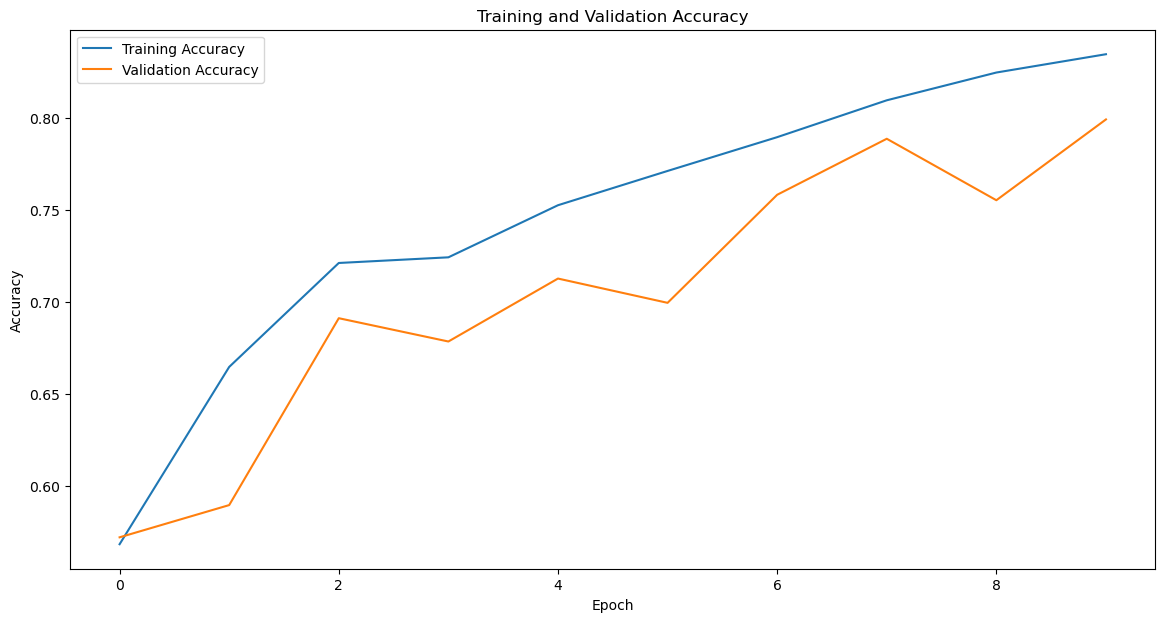

In [33]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# save model
model.save('encoder_test.h5', include_optimizer=False)

# Downstream Task

In [43]:
model = load_model('encoder_test.h5', compile=False)

model.summary()

Model: "contrastive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 32)           532896      ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 reshape_3 (Reshape)            (None, 32, 1)        0           ['encoder[0][0]']      

2024-07-28 18:12:03.688537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 18:12:03.689000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 18:12:03.689536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [44]:
# encoder_model = load_model('best_model.h5', compile=True)
encoder_model = load_model('encoder_test.h5', compile=False)
encoder_model.trainable = False  # Freeze the encoder model

x_input = Input(input_shape)
x = encoder_model(x_input)
x = Reshape((-1, 1))(x)
x = GRU(256, return_sequences=False)(x)
# x = LSTM(512, return_sequences=False, activation='relu')(x)
x = Dense(16, activation='linear')(x)
x = Dense(1, activation='sigmoid')(x)

forecasting_model = Model(x_input, x)
# forecasting_model.compile(optimizer='adam', loss='mse')
forecasting_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
forecasting_model.summary()

2024-07-28 18:12:22.738373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 18:12:22.738811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 18:12:22.739289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

AssertionError: Exception encountered when calling layer "contrastive" (type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.math.sigmoid_2/Sigmoid:0', description="created by layer 'tf.math.sigmoid_2'")

Call arguments received by layer "contrastive" (type Functional):
  • inputs=tf.Tensor(shape=(None, 128, 1), dtype=float32)
  • training=None
  • mask=None

In [126]:
# round positive values to +1 and negative to -1 
y_train = np.where(y_train > 0, 1., 0)
y_test = np.where(y_test > 0, 1., 0)

In [127]:
# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

## With Encoder

In [128]:
forecasting_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Epoch 1/10


2024-07-28 17:22:01.107413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 17:22:01.108301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 17:22:01.110229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

234/235 [============================>.] - ETA: 0s - loss: 0.6848 - binary_accuracy: 0.5707

2024-07-28 17:22:16.608376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 17:22:16.609036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 17:22:16.609661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - 17s 68ms/step - loss: 0.6848 - binary_accuracy: 0.5709 - val_loss: 0.7005 - val_binary_accuracy: 0.5247
Epoch 2/10
235/235 [==============================] - 15s 66ms/step - loss: 0.6821 - binary_accuracy: 0.5753 - val_loss: 0.6981 - val_binary_accuracy: 0.5247
Epoch 3/10
235/235 [==============================] - 15s 62ms/step - loss: 0.6817 - binary_accuracy: 0.5771 - val_loss: 0.6936 - val_binary_accuracy: 0.5265
Epoch 4/10
235/235 [==============================] - 15s 63ms/step - loss: 0.6814 - binary_accuracy: 0.5759 - val_loss: 0.6964 - val_binary_accuracy: 0.5276
Epoch 5/10
235/235 [==============================] - 14s 62ms/step - loss: 0.6815 - binary_accuracy: 0.5753 - val_loss: 0.6988 - val_binary_accuracy: 0.5247
Epoch 6/10
235/235 [==============================] - 14s 60ms/step - loss: 0.6807 - binary_accuracy: 0.5782 - val_loss: 0.7001 - val_binary_accuracy: 0.5223
Epoch 7/10
235/235 [==============================] - 14s 60ms/

KeyboardInterrupt: 

## Without Encoder

In [67]:
# Define the model without the encoder
x_input = Input(shape=input_shape)
x = Reshape((-1, 1))(x_input)
x = GRU(256, return_sequences=False)(x)
# x = LSTM(256, return_sequences=False, activation='relu')(x)
x = Dense(16, activation='linear')(x)
x = Dense(1, activation='sigmoid')(x)

forecasting_model = Model(inputs=x_input, outputs=x)
forecasting_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
forecasting_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 reshape_8 (Reshape)         (None, 128, 1)            0         
                                                                 
 gru_2 (GRU)                 (None, 256)               198912    
                                                                 
 dense_13 (Dense)            (None, 16)                4112      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 203,041
Trainable params: 203,041
Non-trainable params: 0
_________________________________________________________________


2024-07-28 17:00:31.280014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 17:00:31.280525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 17:00:31.281193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [68]:
# Round positive values to +1 and negative to -1
y_train = np.where(y_train > 0, 1., 0)
y_test = np.where(y_test > 0, 1., 0)

In [69]:
# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

# Train the model
forecasting_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Epoch 1/10


2024-07-28 17:00:52.690690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 17:00:52.691701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 17:00:52.692345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - ETA: 0s - loss: 0.6822 - binary_accuracy: 0.5769

2024-07-28 17:01:31.824066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-28 17:01:31.824563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-28 17:01:31.825032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - 43s 178ms/step - loss: 0.6822 - binary_accuracy: 0.5769 - val_loss: 0.7057 - val_binary_accuracy: 0.5249
Epoch 2/10
235/235 [==============================] - 42s 180ms/step - loss: 0.6809 - binary_accuracy: 0.5777 - val_loss: 0.6944 - val_binary_accuracy: 0.5247
Epoch 3/10
201/235 [========================>.....] - ETA: 5s - loss: 0.6809 - binary_accuracy: 0.5776

KeyboardInterrupt: 